In [2]:
import pandas as pd
import re

# Re-load data
ep_df = pd.read_excel("EP_Katalog.xlsx")
ep_df = ep_df[ep_df["Artikelnummer"].notna()].copy()

# Improved parser
def parse_bezeichnung_safe(row):
    desc = str(row["Kurztext / Bezeichnung"])
    
    # Pre-clean: normalize ; and - spacing
    desc = desc.replace("; ", ";").replace(" - ", " - ").strip()
    
    # Step 1: Extract KGR
    kgr_match = re.match(r"^(\d{3})\s*-\s*", desc)
    if kgr_match:
        kgr = kgr_match.group(1)
        remainder = desc[kgr_match.end():]
    else:
        kgr = None
        remainder = desc
    
    # Step 2: Safely split components on ` - ` and `;`
    components = re.split(r"\s*-\s*|\s*;\s*", remainder)

    # Step 3: Field slots
    category = None
    mechanism = None
    medium = None
    quantity = None
    subtype = None
    others = []

    for part in components:
        norm = part.lower().strip()

        if not category:
            category = part
            continue

        elif re.search(r"\b(kraftbetrieben|nicht kraftbetrieben|elektrisch|mechanisch)\b", norm):
            mechanism = part

        elif re.search(r"\bargon|stickstoff|schaum|wasser|co2|fettbrand\b", norm):
            medium = part

        elif re.search(r"(breite|höhe|flügel|inhalt|durchmesser|anz\.)", norm) and re.search(r"(<=|>=|<|>|bis|\d)", norm):
            quantity = part

        elif not subtype and ("schutz" in norm or "funktion" in norm or "anlage" in norm):
            subtype = part

        else:
            others.append(part)

    return pd.Series({
        "KGR": kgr,
        "Category": category,
        "Mechanism": mechanism,
        "Medium": medium,
        "Quantity": quantity,
        "Subtype": subtype,
        "Other1": others[0] if len(others) > 0 else None,
        "Other2": others[1] if len(others) > 1 else None,
        "RawComponents": components
    })

# Apply new parser
parsed_df = ep_df.copy()
parsed_fields = parsed_df.apply(parse_bezeichnung_safe, axis=1)
parsed_df = pd.concat([parsed_df, parsed_fields], axis=1)

# Show clean sample
print(parsed_df[[
    "Kurztext / Bezeichnung", "Artikelnummer", "KGR", "Category",
    "Mechanism", "Medium", "Quantity", "Subtype", "Other1", "Other2"
]].head(20))


                               Kurztext / Bezeichnung        Artikelnummer  \
3   334 - Fenster mit Kipp- oder Drehflügel - kraf...  334.01.01.000.01.00   
4   334 - Fenster mit Kipp- oder Drehflügel - nich...  334.01.01.000.02.00   
5   334 - Hochwasserschutzfenster - nicht kraftbet...  334.01.02.000.01.00   
6   334 - Falttor - kraftbetrieben - Breite < 8 m;...  334.02.01.000.01.01   
7   334 - Falttor - nicht kraftbetrieben - Breite ...  334.02.01.000.02.01   
8   334 - Rolltore / Rollgittertore - kraftbetrieb...  334.02.01.000.03.01   
9   334 - Rolltore / Rollgittertore - nicht kraftb...  334.02.01.000.04.01   
10  334 - Schiebetore (inkl. Feststellanlage) - kr...  334.02.01.000.05.01   
11  334 - Schiebetore (inkl. Feststellanlage) - ni...  334.02.01.000.06.01   
12  334 - Schiebetore (inkl. Feststellanlage) - kr...  334.02.01.000.07.01   
13  334 - Schiebetore (inkl. Feststellanlage) - ni...  334.02.01.000.08.01   
14  334 - Schnelllauftore - kraftbetrieben - Breit...  334.02.01

In [3]:
import re

cust_fp = "Kundendatei.xlsx"
cust_df = pd.read_excel(cust_fp)

def extract_kostengruppe(merkmal):
    if pd.isnull(merkmal):
        return None
    match = re.search(r'Kostengruppe DIN 276-1:\s*(\d{3})', str(merkmal))
    if match:
        return match.group(1)
    return None


# Look through all EQ-Merkmal columns to find a Kostengruppe
def search_kostengruppe_in_all(row):
    for col in row.index:
        if 'EQ-Merkmal' in col:
            match = extract_kostengruppe(row[col])
            if match:
                return match
    return None

# Apply row-wise
cust_df['Extracted_Kostengruppe'] = cust_df.apply(search_kostengruppe_in_all, axis=1)

# Check again
cust_df[['EQ-Bezeichnung', 'Extracted_Kostengruppe']].head(10)


,EQ-Bezeichnung,Extracted_Kostengruppe
0,Schutzraumlüftung - Mitt.(Außer Betrieb),431
1,RLT Batterieraum alt - Mittelbau,431
2,RLT Gleichr. alt - Mittelbau,431
3,"Gebäude-Blitzschutz-, Erdungsanl., Pot.",446
4,Beschallungs-/Sprechanlagen,454
5,"WTA Entwässerungspumpen, ortsfest",411
6,Niederspannungsleitungsanlage,444
7,"Innenbeleuchtung, ortsfest",445
8,Wasserverteilanlage,412
9,Laufkatzenanlage,465


In [4]:
print("Grouping found:", cust_df['Extracted_Kostengruppe'].notna().sum())
print("No group found:", cust_df['Extracted_Kostengruppe'].isna().sum())

Grouping found: 913
No group found: 60


In [5]:
# First deal with the ones who has cost groups:

cost_group_has_cust_df = cust_df.dropna(subset=['Extracted_Kostengruppe']).copy()
print(cost_group_has_cust_df)



     WirtEinh  EQ_übergeordnet   Equipment  \
0       21083              NaN  1000005794   
1       21083              NaN  1000005932   
2       21083              NaN  1000005934   
3       21083              NaN  1000025596   
4       21083              NaN  1000026066   
..        ...              ...         ...   
968     26287              NaN  1010136947   
969     26287              NaN  1010136948   
970     26287              NaN  1010136949   
971     26287              NaN  1010136950   
972     26287              NaN  1010136951   

                               EQ-Bezeichnung  EQ-Klasse  \
0    Schutzraumlüftung - Mitt.(Außer Betrieb)      31211   
1            RLT Batterieraum alt - Mittelbau      31211   
2                RLT Gleichr. alt - Mittelbau      31211   
3     Gebäude-Blitzschutz-, Erdungsanl., Pot.       3330   
4                 Beschallungs-/Sprechanlagen       3520   
..                                        ...        ...   
968                   Trink

In [6]:
arr_KGR = parsed_df['KGR'].unique()

In [7]:
cost_group_has_cust_df['Extracted_Kostengruppe'].unique()

array(['431', '446', '454', '411', '444', '445', '412', '465', '452',
       '475', '456', '421', '471', '432', '469', '419', '369', '362',
       '344', '455', '461', '463', '435', '439', '482', '453', '442',
       '334', '413', '359', '474'], dtype=object)

In [8]:
# Take the ones that are in our catalogue first, later we can create the ones that are not.

# Step 2: Filter your dataset to only include rows where the KGR is in the catalog
valid_cost_groups_df = cost_group_has_cust_df[
    cost_group_has_cust_df['Extracted_Kostengruppe'].isin(arr_KGR)
]

# Step 3: (Optional) Store the others for later processing
invalid_cost_groups_df = cost_group_has_cust_df[
    ~cost_group_has_cust_df['Extracted_Kostengruppe'].isin(arr_KGR)
]


In [9]:
valid_cost_groups_df

,WirtEinh,EQ_übergeordnet,Equipment,EQ-Bezeichnung,EQ-Klasse,EQ-Klasse-Bezeichnung,Gewerk,Anlagenausprägung,EQ-Menge,EQ-Merkmal_001,...,EQ-Merkmal_044,EQ-Merkmal_045,EQ-Merkmal_046,EQ-Merkmal_047,EQ-Merkmal_048,EQ-Merkmal_049,EQ-Merkmal_050,EQ-Merkmal_051,EQ-Merkmal_052,Extracted_Kostengruppe
0,21083,NaN,1000005794,Schutzraumlüftung - Mitt.(Außer Betrieb),31211,Lüftungsanlagen,RLT,Schutzraumlüft. ohne Sandfilt.,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431
1,21083,NaN,1000005932,RLT Batterieraum alt - Mittelbau,31211,Lüftungsanlagen,RLT,Zu-/Abluftanlage,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431
2,21083,NaN,1000005934,RLT Gleichr. alt - Mittelbau,31211,Lüftungsanlagen,RLT,Zu-/Abluftanlage,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431
3,21083,NaN,1000025596,"Gebäude-Blitzschutz-, Erdungsanl., Pot.",3330,Blitzschutz-/Erdungsanlage,Elektro Blitzschutz,Blitzschutz/Erdung Gebäude,1,Ableiter Anzahl aussen: 11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,446
4,21083,NaN,1000026066,Beschallungs-/Sprechanlagen,3520,Elektroakustische Anlagen,Haustechn Einricht,Beschallungsanlage,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,22225,NaN,1010104388,Neutralisationsanlage,32303,Abwasserbehandlunganlagen,Sanitär,Neutralisationsanlage,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411
964,22225,1.003278e+09,1010112621,Z004_E_16b_X_Server-Raum,35603,IZS-Komponenten,"BuES, GLT, IZS",Zugangstür,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456
965,22225,1.003278e+09,1010112622,L004_E_16b_X_Server-Raum,35603,IZS-Komponenten,"BuES, GLT, IZS",Kartenleser eines Zugangs,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456
966,15859,NaN,1010136819,HHWB17182103_01,35602,IZS-Zutrittskontrollzentrale,"BuES, GLT, IZS",IDT,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456


In [10]:
# === Identify relevant columns ===
# All columns that start with "EQ-Merkmal_" are important
merkmal_cols = [col for col in valid_cost_groups_df.columns if col.startswith("EQ-Merkmal_")]
descriptor_cols = ["EQ-Bezeichnung", "Anlagenausprägung"] + merkmal_cols

# === Clean and convert to lowercase strings ===
valid_cost_groups_df[descriptor_cols] = valid_cost_groups_df[descriptor_cols].astype(str).apply(
    lambda x: x.str.lower().str.strip()
)

# === Combine relevant fields into a descriptor list ===
def build_descriptor_list(row):
    return [val for val in row if val not in ["", "nan", "none"]]

valid_cost_groups_df["Customer_descriptor_list"] = valid_cost_groups_df[descriptor_cols].apply(build_descriptor_list, axis=1)

# === Drop rows where descriptor list is empty ===
valid_cost_groups_df = valid_cost_groups_df[valid_cost_groups_df["Customer_descriptor_list"].str.len() > 0].copy()

# === Preview a few ===
print(valid_cost_groups_df[["Customer_descriptor_list"]].head(10))


                            Customer_descriptor_list
0  [schutzraumlüftung - mitt.(außer betrieb), sch...
1  [rlt batterieraum alt - mittelbau, zu-/ablufta...
2  [rlt gleichr. alt - mittelbau, zu-/abluftanlag...
3  [gebäude-blitzschutz-, erdungsanl., pot., blit...
4  [beschallungs-/sprechanlagen, beschallungsanla...
5  [wta entwässerungspumpen, ortsfest, entwässeru...
6  [niederspannungsleitungsanlage, niederspannung...
7  [innenbeleuchtung, ortsfest, innenbel.einr. or...
8  [wasserverteilanlage, wasserverteilanlage, fil...
9  [laufkatzenanlage, laufkatzenanlage, belastung...


C:\Users\LENOVO\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [11]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    if not set1 or not set2:
        return 0
    return len(set1 & set2) / len(set1 | set2)


In [12]:
# Define normalization helper
def normalize(x):
    if isinstance(x, str):
        return x.lower().strip().replace("ä", "ae").replace("ö", "oe").replace("ü", "ue")
    return ""

# Create 'Catalog_descriptor_list' from parsed fields
def create_catalog_descriptor_list(row):
    fields = ["Category", "Mechanism", "Medium", "Quantity", "Subtype", "Other1", "Other2"]
    descriptor = [normalize(row[f]) for f in fields if normalize(row[f])]
    return descriptor

# Apply to parsed_df
parsed_df["Catalog_descriptor_list"] = parsed_df.apply(create_catalog_descriptor_list, axis=1)


In [13]:
from tqdm import tqdm

matched_ep_numbers = []

for _, row in tqdm(valid_cost_groups_df.iterrows(), total=len(valid_cost_groups_df)):
    cust_kgr = row["Extracted_Kostengruppe"]
    cust_desc = row["Customer_descriptor_list"]

    # Filter catalog rows by same KGR
    candidates = parsed_df[parsed_df["KGR"] == cust_kgr]

    best_match = None
    best_score = 0

    for _, cat_row in candidates.iterrows():
        cat_desc = cat_row["Catalog_descriptor_list"]
        score = jaccard_similarity(cust_desc, cat_desc)

        if score > best_score:
            best_score = score
            best_match = cat_row["Artikelnummer"]

    matched_ep_numbers.append(best_match)


100%|██████████| 794/794 [00:05<00:00, 141.41it/s]


In [14]:
valid_cost_groups_df["first_EP_trial"] = matched_ep_numbers

In [15]:
valid_cost_groups_df["first_EP_trial"].notna().sum()

50

In [16]:
missing_kgrs = valid_cost_groups_df["Extracted_Kostengruppe"].unique()
catalog_kgrs = parsed_df["KGR"].unique()
unmatched_kgrs = set(missing_kgrs) - set(catalog_kgrs)
print(f"KGRs with no catalog entries: {unmatched_kgrs}")

KGRs with no catalog entries: set()


In [17]:
import pandas as pd
import re
from rapidfuzz import fuzz

# --- Normalize a single token: lowercase, strip, remove spaces, unify German chars ---
def normalize_token(token):
    token = str(token).lower().strip()
    token = token.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ß", "ss")
    token = token.replace(" ", "")
    return token

# --- Apply normalization to a list of tokens ---
def normalize_token_list(tokens):
    return [normalize_token(t) for t in tokens if pd.notna(t) and str(t).strip() != ""]

# --- Synonym dictionary ---
SYNONYMS = {
    "rolltor": "rolltore",
    "rollgittertor": "rolltore",
    "elektrisch": "kraftbetrieben",
    "mechanisch": "nichtkraftbetrieben",
    # Add more as you discover
}

# --- Replace synonyms in token list ---
def apply_synonyms(tokens, synonym_dict=SYNONYMS):
    return [synonym_dict.get(t, t) for t in tokens]


In [18]:
def fuzzy_similarity(str1, str2):
    # Use token sort ratio (ignores token order)
    return fuzz.token_sort_ratio(str1, str2) / 100.0  # scale to 0..1


In [19]:
def extract_numeric_phrases(text):
    if pd.isna(text) or not isinstance(text, str):
        return []

    text = text.lower()

    patterns = [
        r"[<>]=?\s*\d+",             # >= 500, <= 300, >200
        r"\bbis\s+\d+",              # bis 75000
        r"\bvon\s+\d+\s+bis\s+\d+",  # von 500 bis 1000
        r"\b\d+\s*(mm|cm|m|l|kw|w|kwh|db)?\b"  # bare numbers with optional units
    ]

    matches = []
    for pattern in patterns:
        matches += re.findall(pattern, text)

    return matches

In [20]:
def find_best_catalog_match(cust_tokens, cust_str, catalog_df, cust_anlagenauspraegung=None):
    """
    cust_tokens: list of tokens (normalized & synonym-applied) from customer descriptor
    cust_str: original full customer descriptor string (for fuzzy fallback)
    catalog_df: subset of parsed_df for the same KGR
    cust_anlagenauspraegung: string describing system subtype (optional but recommended)

    Returns: dict with best match info or None if no match found
    """
    best_match = None
    best_score = 0.0

    for _, cat_row in catalog_df.iterrows():
        cat_tokens_raw = cat_row.get("Catalog_descriptor_list", [])
        if not cat_tokens_raw:
            continue

        # Normalize and synonym replace catalog tokens
        cat_tokens = normalize_token_list(cat_tokens_raw)
        cat_tokens = apply_synonyms(cat_tokens)

        # Similarities
        jaccard = jaccard_similarity(cust_tokens, cat_tokens)
        fuzzy_score = 0
        if jaccard == 0 and isinstance(cat_row.get("Kurztext / Bezeichnung"), str):
            cat_str = cat_row["Kurztext / Bezeichnung"].lower()
            fuzzy_score = fuzzy_similarity(cust_str.lower(), cat_str)

        # Bonus: Numeric match boost
        cust_numbers = extract_numeric_phrases(cust_str)
        cat_numbers = extract_numeric_phrases(" ".join(cat_row.get("RawComponents", [])))
        numeric_overlap = len(set(cust_numbers) & set(cat_numbers))
        has_number_bonus = 0.1 * numeric_overlap if numeric_overlap > 0 else 0

        # Bonus: Anlagenausprägung match
        anlagen_bonus = 0
        if cust_anlagenauspraegung and "Anlagenausprägung" in cat_row:
            if str(cust_anlagenauspraegung).strip().lower() == str(cat_row["Anlagenausprägung"]).strip().lower():
                anlagen_bonus = 0.2  # Adjustable

        final_score = max(jaccard, fuzzy_score) + has_number_bonus + anlagen_bonus

        if final_score > best_score:
            best_score = final_score
            best_match = {
                "Artikelnummer": cat_row["Artikelnummer"],
                "Score": round(final_score, 4),
                "BaseScore": round(max(jaccard, fuzzy_score), 4),
                "NumberOverlap": numeric_overlap,
                "AnlagenausprägungBonus": anlagen_bonus,
                "Matched_KGR": cat_row.get("KGR"),
                "Matched_Descriptor": cat_row.get("Kurztext / Bezeichnung", "")
            }

    return best_match if best_match else None


In [21]:
# Prepare catalog tokens column (if not already done)
if "Catalog_descriptor_list" not in parsed_df.columns:
    cols_to_concat = ["Category", "Mechanism", "Medium", "Quantity", "Subtype", "Other1", "Other2"]
    parsed_df["Catalog_descriptor_list"] = parsed_df[cols_to_concat].fillna("").astype(str).apply(
        lambda row: [x.lower().strip() for x in row if x and x.lower().strip() not in ["none", "nan", ""]], axis=1
    )


In [22]:
results = []

for idx, cust_row in valid_cost_groups_df.iterrows():
    cust_kgr = str(cust_row["Extracted_Kostengruppe"]).strip()
    cust_tokens_raw = cust_row["Customer_descriptor_list"]
    cust_tokens = normalize_token_list(cust_tokens_raw)
    cust_tokens = apply_synonyms(cust_tokens)
    cust_str = " ".join(cust_tokens_raw)  # original tokens joined for fuzzy fallback

    cust_anlagenauspraegung = cust_row.get("Anlagenausprägung")

    # Filter catalog by matching KGR only
    catalog_candidates = parsed_df[parsed_df["KGR"] == cust_kgr]

    if catalog_candidates.empty:
        results.append({
            "index": idx,
            "second_EP_trial": None,
            "score": 0,
            "reason": f"No catalog entries for KGR {cust_kgr}"
        })
        continue

    best_match = find_best_catalog_match(
        cust_tokens,
        cust_str,
        catalog_candidates,
        cust_anlagenauspraegung=cust_anlagenauspraegung
    )

    if best_match:
        results.append({
            "index": idx,
            "second_EP_trial": best_match["Artikelnummer"],
            "score": best_match["Score"],
            "reason": "Match found"
        })
    else:
        results.append({
            "index": idx,
            "second_EP_trial": None,
            "score": 0,
            "reason": "No match above 0 similarity"
        })

# Convert results to DataFrame and merge back
results_df = pd.DataFrame(results).set_index("index")
valid_cost_groups_df = valid_cost_groups_df.join(results_df[["second_EP_trial", "score", "reason"]])


In [23]:
print(valid_cost_groups_df[["Extracted_Kostengruppe", "Customer_descriptor_list", "second_EP_trial", "score", "reason"]].head(20))


   Extracted_Kostengruppe                           Customer_descriptor_list  \
0                     431  [schutzraumlüftung - mitt.(außer betrieb), sch...   
1                     431  [rlt batterieraum alt - mittelbau, zu-/ablufta...   
2                     431  [rlt gleichr. alt - mittelbau, zu-/abluftanlag...   
3                     446  [gebäude-blitzschutz-, erdungsanl., pot., blit...   
4                     454  [beschallungs-/sprechanlagen, beschallungsanla...   
5                     411  [wta entwässerungspumpen, ortsfest, entwässeru...   
6                     444  [niederspannungsleitungsanlage, niederspannung...   
7                     445  [innenbeleuchtung, ortsfest, innenbel.einr. or...   
8                     412  [wasserverteilanlage, wasserverteilanlage, fil...   
9                     465  [laufkatzenanlage, laufkatzenanlage, belastung...   
10                    444  [niederspannungsleitungsanlage, niederspannung...   
11                    411  [abwasserleit

In [24]:
print("Matches assigned:", valid_cost_groups_df['second_EP_trial'].notna().sum())
print("Not matched:", valid_cost_groups_df['second_EP_trial'].isna().sum())

Matches assigned: 794
Not matched: 0


In [25]:
valid_cost_groups_df[['first_EP_trial', 'second_EP_trial']]

,first_EP_trial,second_EP_trial
0,None,431.03.01.000.02.08
1,None,431.03.01.000.02.08
2,None,431.03.01.000.01.03
3,None,446.01.01.216.00.00
4,None,454.01.01.000.00.02
...,...,...
962,411.04.04.000.00.00,411.05.01.012.02.02
964,None,456.03.01.000.00.02
965,None,456.03.01.000.00.02
966,None,456.03.01.000.00.02


In [26]:
valid_cost_groups_df_check = valid_cost_groups_df.dropna(subset=['first_EP_trial']).copy()

In [27]:
diff_rows = valid_cost_groups_df_check[
    valid_cost_groups_df_check["first_EP_trial"] != valid_cost_groups_df_check["second_EP_trial"]
]

In [28]:
print(diff_rows[["Anlagenausprägung", "first_EP_trial", "second_EP_trial"]].head(50))


         Anlagenausprägung       first_EP_trial      second_EP_trial
64            abluftanlage  431.01.01.021.00.00  431.03.01.000.01.08
72            abluftanlage  431.01.01.021.00.00  431.03.01.000.02.05
74            abluftanlage  431.01.01.021.00.00  431.03.01.000.02.04
75            abluftanlage  431.01.01.021.00.00  431.03.01.000.01.06
76            abluftanlage  431.01.01.021.00.00  431.03.01.000.02.05
77            abluftanlage  431.01.01.021.00.00  431.03.01.000.02.05
97          fettabscheider  411.04.02.000.00.01  411.05.01.012.01.02
98          fettabscheider  411.04.02.000.00.01  411.05.01.012.01.02
117       brandmeldeanlage  456.01.01.000.00.00  456.03.01.000.00.02
119       brandmeldeanlage  456.01.01.000.00.00  456.03.01.000.00.02
120       brandmeldeanlage  456.01.01.000.00.00  456.03.01.000.00.02
191       brandmeldeanlage  456.01.01.000.00.00  456.03.01.000.00.02
206           abluftanlage  431.01.01.021.00.00  431.03.01.000.01.08
236         fettabscheider  411.04

In [29]:
print(f"Total mismatches: {len(diff_rows)}")

Total mismatches: 50


In [30]:
# Map Artikelnummer to description
artikel_to_desc = parsed_df.set_index("Artikelnummer")["Kurztext / Bezeichnung"].to_dict()

In [31]:
diff_rows["first_EP_description"] = diff_rows["first_EP_trial"].map(artikel_to_desc)
diff_rows["second_EP_description"] = diff_rows["second_EP_trial"].map(artikel_to_desc)


In [32]:
# Export the result to Excel
diff_rows_to_export = diff_rows[[
    "first_EP_trial", "second_EP_trial", "score", "reason",
    "first_EP_description", "second_EP_description"
]]

diff_rows_to_export.to_excel("EP_Trial_Comparison_Differences.xlsx", index=False)

In [1]:
from sentence_transformers import SentenceTransformer

# Load the multilingual SBERT model (handles German)
sbert_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

print("✅ SBERT model loaded successfully.")

✅ SBERT model loaded successfully.


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Extract catalog texts and IDs
catalog_texts = ep_df["Kurztext / Bezeichnung"].astype(str).tolist()
catalog_ids = ep_df["Artikelnummer"].tolist()

# Encode catalog descriptions
catalog_embeddings = sbert_model.encode(catalog_texts, convert_to_tensor=True)

print(f"✅ Encoded {len(catalog_texts)} catalog entries")


✅ Encoded 614 catalog entries


In [34]:
from tqdm import tqdm

# Store results here
third_EP_trials = []
third_EP_scores = []

# Ensure tqdm doesn't crash in notebooks
tqdm.pandas()

# Main loop
for _, row in tqdm(valid_cost_groups_df.iterrows(), total=len(valid_cost_groups_df)):
    # Get the preprocessed descriptor tokens (after synonym normalization)
    tokens = row["Customer_descriptor_list"]  # Already normalized list
    joined = " ".join(tokens)

    # Encode customer string
    cust_emb = sbert_model.encode(joined, convert_to_tensor=True)

    # Compute cosine similarity to all catalog entries
    similarities = cosine_similarity(cust_emb.cpu().numpy().reshape(1, -1), catalog_embeddings.cpu().numpy())[0]

    # Get best match
    best_idx = np.argmax(similarities)
    best_ep = catalog_ids[best_idx]
    best_score = similarities[best_idx]

    third_EP_trials.append(best_ep)
    third_EP_scores.append(best_score)


100%|██████████| 794/794 [02:29<00:00,  5.32it/s]


In [35]:
valid_cost_groups_df["third_EP_trial"] = third_EP_trials
valid_cost_groups_df["third_EP_score"] = third_EP_scores


In [36]:
# Merge for first_EP_trial
first_desc = ep_df[["Artikelnummer", "Kurztext / Bezeichnung"]].rename(
    columns={"Artikelnummer": "first_EP_trial", "Kurztext / Bezeichnung": "first_EP_description"}
)
valid_cost_groups_df = valid_cost_groups_df.merge(first_desc, on="first_EP_trial", how="left")

# Merge for second_EP_trial
second_desc = ep_df[["Artikelnummer", "Kurztext / Bezeichnung"]].rename(
    columns={"Artikelnummer": "second_EP_trial", "Kurztext / Bezeichnung": "second_EP_description"}
)
valid_cost_groups_df = valid_cost_groups_df.merge(second_desc, on="second_EP_trial", how="left")

# Merge for third_EP_trial (SBERT)
third_desc = ep_df[["Artikelnummer", "Kurztext / Bezeichnung"]].rename(
    columns={"Artikelnummer": "third_EP_trial", "Kurztext / Bezeichnung": "third_EP_description"}
)
valid_cost_groups_df = valid_cost_groups_df.merge(third_desc, on="third_EP_trial", how="left")


In [37]:
compare_df = valid_cost_groups_df[
    [
        "Extracted_Kostengruppe",
        "Customer_descriptor_list",
        "first_EP_trial", "first_EP_description",
        "second_EP_trial", "second_EP_description",
        "third_EP_trial", "third_EP_description",
        "third_EP_score"
    ]
]

# Sort by score descending to see best SBERT matches
compare_df = compare_df.sort_values("third_EP_score", ascending=False)
compare_df.head(20)


,Extracted_Kostengruppe,Customer_descriptor_list,first_EP_trial,first_EP_description,second_EP_trial,second_EP_description,third_EP_trial,third_EP_description,third_EP_score
782,445,"[sicherheitsbeleuchtung led, sicherheitsl.einz...",None,NaN,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.546270
465,445,"[fluchtwegbeleuchtung, sicherheitsl.einzel ort...",None,NaN,445.02.01.007.04.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.535154
445,445,"[sicherheitshandleuchten, sicherheitsl.einzel ...",None,NaN,445.02.02.200.01.00,445 - optische Sicherheitsleitsysteme - Sicher...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.533054
663,445,"[sicherheitsleuchten, einzelne, sicherheitsl.e...",None,NaN,445.02.02.200.01.00,445 - optische Sicherheitsleitsysteme - Sicher...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.528348
477,445,"[nothandleuchte, sicherheitsl.einzel ortsverän...",None,NaN,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.526330
472,445,"[nothandleuchte, sicherheitsl.einzel ortsverän...",None,NaN,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.526330
653,445,"[kantine sicherheitsbeleuchtung/einzel, sicher...",None,NaN,445.02.01.007.04.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.01.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.516125
781,445,"[fluchtwegbeleuchtung led, sicherheitsl.einzel...",None,NaN,445.02.01.007.04.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.516114
464,445,"[nothandleuchte r.0112, sicherheitsl.einzel or...",None,NaN,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,445.02.01.007.02.00,445 - Sicherheitsbeleuchtungsanlage - Leuchte ...,0.506212
244,431,"[ablüfter 2, wc, abluftgerät, brandlüftung: ke...",None,NaN,431.01.01.000.00.04,431 - Abluftanlagen (mit bis zu einer LBF) - A...,334.03.01.000.11.02,334 - Schiebetür (ohne Fluchtwegsfunktion); ni...,0.505416


In [38]:
valid_cost_groups_df["SBERT_matches_first"] = (
    valid_cost_groups_df["third_EP_trial"] == valid_cost_groups_df["first_EP_trial"]
)

valid_cost_groups_df["SBERT_matches_second"] = (
    valid_cost_groups_df["third_EP_trial"] == valid_cost_groups_df["second_EP_trial"]
)


In [40]:
agreement_stats = {
    "SBERT & First Trial agree": valid_cost_groups_df["SBERT_matches_first"].sum(),
    "SBERT & Second Trial agree": valid_cost_groups_df["SBERT_matches_second"].sum(),
    "SBERT agrees with neither": (
        (~valid_cost_groups_df["SBERT_matches_first"]) & (~valid_cost_groups_df["SBERT_matches_second"])
    ).sum(),
    "Total": len(valid_cost_groups_df),
}

pd.DataFrame.from_dict(agreement_stats, orient="index", columns=["Count"])


,Count
SBERT & First Trial agree,0
SBERT & Second Trial agree,56
SBERT agrees with neither,738
Total,794


In [41]:
export_df = valid_cost_groups_df[
    [
        "Extracted_Kostengruppe",
        "Customer_descriptor_list",
        "first_EP_trial", "first_EP_description",
        "second_EP_trial", "second_EP_description",
        "third_EP_trial", "third_EP_description",
        "third_EP_score",
        "SBERT_matches_first",
        "SBERT_matches_second"
    ]
]

In [42]:
export_path = "EP_comparison_SBERT.xlsx"
export_df.to_excel(export_path, index=False)
print(f"✅ Exported to {export_path}")

✅ Exported to EP_comparison_SBERT.xlsx


In [46]:
# Filter rows with specific second_EP_trial value
target_ep = "412.02.04.000.00.02"
filtered_rows = valid_cost_groups_df[valid_cost_groups_df["second_EP_trial"] == target_ep]

In [50]:
filtered_rows

,WirtEinh,EQ_übergeordnet,Equipment,EQ-Bezeichnung,EQ-Klasse,EQ-Klasse-Bezeichnung,Gewerk,Anlagenausprägung,EQ-Menge,EQ-Merkmal_001,...,second_EP_trial,score,reason,third_EP_trial,third_EP_score,first_EP_description,second_EP_description,third_EP_description,SBERT_matches_first,SBERT_matches_second
74,15859,NaN,1000631080,w-druckerhöhung,32204,Wasserdruckerhöhungsanlagen,Sanitär,wasserdruckerhöhungsanlage,1,schnittstelle bues/glt: bues,...,412.02.04.000.00.02,0.4938,Match found,412.02.05.012.00.04,0.477770,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Druckerhöhungsanlagen (nicht Löschwasser...,False,False
75,15859,NaN,1000631093,w-druckerhöhung,32204,Wasserdruckerhöhungsanlagen,Sanitär,wasserdruckerhöhungsanlage,1,schnittstelle bues/glt: bues,...,412.02.04.000.00.02,0.4938,Match found,412.02.05.012.00.04,0.477770,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Druckerhöhungsanlagen (nicht Löschwasser...,False,False
77,15859,NaN,1000631520,brunnen,32202,Wassergewinnungsanlagen,Sanitär,brunnen,1,auflagen einer behörde: keine,...,412.02.04.000.00.02,0.4726,Match found,334.01.02.000.01.00,0.349049,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,334 - Hochwasserschutzfenster - nicht kraftbet...,False,False
78,15859,NaN,1000631584,zisterne kats-gebäude,32202,Wassergewinnungsanlagen,Sanitär,zisterne,1,nan,...,412.02.04.000.00.02,0.4887,Match found,412.03.01.229.00.00,0.350966,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Wasserfilter - ohne Rückspülung,False,False
95,15859,NaN,1000634102,snu,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",1,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.5149,Match found,412.05.01.000.00.00,0.371114,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False
96,15859,NaN,1000634122,ebk5,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",16,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.4967,Match found,412.05.01.000.00.00,0.367761,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False
97,15859,NaN,1000634153,wassererwärmungsgeräte ebk5 erwbau,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",3,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.4750,Match found,412.05.01.000.00.00,0.334296,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False
98,15859,NaN,1000634163,snu,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",16,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.5149,Match found,412.05.01.000.00.00,0.371114,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False
99,15859,NaN,1000634242,wasserwärmungsgeräte rz,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",8,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.4831,Match found,412.05.01.000.00.00,0.371876,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False
166,15859,NaN,1000646865,snu,3113,Wassererwärmungsgeräte ortsfest,Elektro,"gerät, elektrisch beheizt",3,hygiene trinkwv/vdi 6023: nein,...,412.02.04.000.00.02,0.5149,Match found,412.05.01.000.00.00,0.371114,NaN,412 - Enteisenungs-/ Entmanganungsanlagen - Du...,412 - Sanitäre Einrichtungsgegenstände (Wascht...,False,False


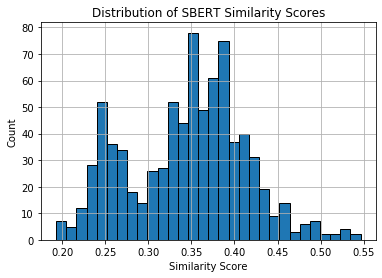

In [54]:
import matplotlib.pyplot as plt

plt.hist(valid_cost_groups_df['third_EP_score'].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of SBERT Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [59]:
## Let us try to increase this similarity score:
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

stop_words = set(stopwords.words("german"))

def clean(text_list):
    if isinstance(text_list, list):
        text = " ".join(text_list)  # Join list into single string
    else:
        text = str(text_list)
        
    text = text.lower()
    text = re.sub(r"[^a-zäöüß0-9\s]", " ", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


valid_cost_groups_df["clean_descriptor"] = valid_cost_groups_df["Customer_descriptor_list"].apply(clean)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### For presentation:
412 - Enteisenungs-/ Entmanganungsanlagen - Durchflussleistung > 1 m3/h bis 5 m3/h -> second trial gave this: 412.02.04.000.00.02
412 - Sanitäre Einrichtungsgegenstände (Waschtisch, Urinale, WC, Duschen, Wannen, etc.) -> SBERT gave this: 412.05.01.000.00.00

In [ ]:
# Did a cleaning wit nltk to the early sbert model with stops words, nothing improved.
# Trying a new model (without readout error at a better computer.). paraphrase-multilingual-MiniLM-L12-v2

### KGR's that customer has and we dont:

#### Rules:

    KGR: The 3-digit cost group.

    .01: Always start with .01 (system level).

    .01: Next, simplest grouping.

    .000: Always start with .000 (placeholding for module level). Maybe comes from the project number assigned ? Inner company thing ? Seems random.

    .AA: Adjective level (categorical variant, e.g., kraftbetrieben vs nicht kraftbetrieben)

    .BB: Numerical variant (e.g., <= 5000 m², 6 m bis 12 m…)

In [85]:
invalid_cost_groups_df['Extracted_Kostengruppe'].unique()

array(['344', '359', '369', '419', '435', '471', '475'], dtype=object)

In [65]:
invalid_cost_groups_df.columns

Index(['WirtEinh', 'EQ_übergeordnet', 'Equipment', 'EQ-Bezeichnung',
       'EQ-Klasse', 'EQ-Klasse-Bezeichnung', 'Gewerk', 'Anlagenausprägung',
       'EQ-Menge', 'EQ-Merkmal_001', 'EQ-Merkmal_002', 'EQ-Merkmal_003',
       'EQ-Merkmal_004', 'EQ-Merkmal_005', 'EQ-Merkmal_006', 'EQ-Merkmal_007',
       'EQ-Merkmal_008', 'EQ-Merkmal_009', 'EQ-Merkmal_010', 'EQ-Merkmal_011',
       'EQ-Merkmal_012', 'EQ-Merkmal_013', 'EQ-Merkmal_014', 'EQ-Merkmal_015',
       'EQ-Merkmal_016', 'EQ-Merkmal_017', 'EQ-Merkmal_018', 'EQ-Merkmal_019',
       'EQ-Merkmal_020', 'EQ-Merkmal_021', 'EQ-Merkmal_022', 'EQ-Merkmal_023',
       'EQ-Merkmal_024', 'EQ-Merkmal_025', 'EQ-Merkmal_026', 'EQ-Merkmal_027',
       'EQ-Merkmal_028', 'EQ-Merkmal_029', 'EQ-Merkmal_030', 'EQ-Merkmal_031',
       'EQ-Merkmal_032', 'EQ-Merkmal_033', 'EQ-Merkmal_034', 'EQ-Merkmal_035',
       'EQ-Merkmal_036', 'EQ-Merkmal_037', 'EQ-Merkmal_038', 'EQ-Merkmal_039',
       'EQ-Merkmal_040', 'EQ-Merkmal_041', 'EQ-Merkmal_042', 'EQ-Merkma

In [67]:
import pandas as pd
import re

def extract_numeric_token(text):
    """Extracts the first numeric value in a string. If none, returns -1 for sorting."""
    numbers = re.findall(r"\d+(?:[\.,]\d+)?", text.replace(",", "."))
    return float(numbers[0]) if numbers else -1

from scipy.stats import rankdata

def extract_numeric_token(text):
    """Extracts the first numeric token (for ordering)"""
    import re
    numbers = re.findall(r"\d+(?:[.,]?\d+)?", text)
    if numbers:
        return float(numbers[0].replace(",", "."))
    else:
        return -1  # or float('inf') if you want non-numerics last

def compute_new_ep_codes(df):
    df = df.copy()

    def assign_ranks(group):
        # Normalize for grouping
        group["text_key"] = group["Anlagenausprägung"].str.lower().str.strip()
        
        # First rank: by distinct textual descriptors
        text_groups = {v: i+1 for i, v in enumerate(sorted(group["text_key"].unique()))}
        group["text_group_id"] = group["text_key"].map(text_groups)

        # Extract number for ordering
        group["numeric_token"] = group["Anlagenausprägung"].apply(extract_numeric_token)

        # Rank within text group by numeric token
        group["numeric_group_id"] = group.groupby("text_group_id")["numeric_token"] \
                                          .transform(lambda x: rankdata(x, method="dense")).astype(int)

        # Final formatting
        group["new_EPs"] = (
            group["Extracted_Kostengruppe"].astype(str).str.zfill(3) + "." +
            group["text_group_id"].astype(str).str.zfill(2) + ".01.000." +
            group["text_group_id"].astype(str).str.zfill(2) + "." +
            group["numeric_group_id"].astype(str).str.zfill(2)
        )

        return group

    # Apply the function per KGR group
    df = df.groupby("Extracted_Kostengruppe", group_keys=False).apply(assign_ranks)

    return df


# === Apply to your DataFrame ===
invalid_cost_groups_df = compute_new_ep_codes(invalid_cost_groups_df)


In [68]:
invalid_cost_groups_df.to_excel("invalid_with_generated_EPs.xlsx", index=False)

In [69]:
# Ensure KGR is string and zero-padded
valid_cost_groups_df["Extracted_Kostengruppe_str"] = valid_cost_groups_df["Extracted_Kostengruppe"].astype(str).str.zfill(3)

# Extract first 3-digit group from third_EP_trial
valid_cost_groups_df["third_EP_prefix"] = valid_cost_groups_df["third_EP_trial"].astype(str).str.extract(r"^(\d{3})")

# Apply logic
valid_cost_groups_df["final_EP"] = valid_cost_groups_df.apply(
    lambda row: row["third_EP_trial"] if row["Extracted_Kostengruppe_str"] == row["third_EP_prefix"]
    else row["second_EP_trial"],
    axis=1
)

# Select only relevant columns for merging
valid_result = valid_cost_groups_df.copy()
valid_result["source"] = "valid"
# valid_result = valid_result[["EQ-Bezeichnung", "Anlagenausprägung", "Extracted_Kostengruppe", "final_EP", "source"]]

# Prepare invalid df
invalid_result = invalid_cost_groups_df.copy()
invalid_result["final_EP"] = invalid_result["new_EPs"]
invalid_result["source"] = "invalid"
# invalid_result = invalid_result[["EQ-Bezeichnung", "Anlagenausprägung", "Extracted_Kostengruppe", "final_EP", "source"]]

# Combine both into one DataFrame
final_dataset = pd.concat([valid_result, invalid_result], ignore_index=True)
final_dataset.to_excel("with_KGR_generated_EPs_final.xlsx", index=False)

### No direct KGR ones:

In [72]:
cost_group_nothas_cust_df = cust_df.loc[cust_df["Extracted_Kostengruppe"].isna()].copy()
print(cost_group_nothas_cust_df)


     WirtEinh  EQ_übergeordnet   Equipment  \
22      21083              NaN  1000033260   
116     15859              NaN  1000636311   
122     15859              NaN  1000636591   
124     15859              NaN  1000636627   
125     15859              NaN  1000636659   
136     15859              NaN  1000638191   
137     15859              NaN  1000638200   
147     15859              NaN  1000639389   
193     15859              NaN  1000650511   
244     26287              NaN  1001307133   
434     15859              NaN  1001490923   
476     26287              NaN  1001747802   
477     26287              NaN  1001747807   
491     15859              NaN  1001838649   
500     15859              NaN  1001838658   
517     26287              NaN  1003129334   
519     26287              NaN  1003129337   
559     26287              NaN  1003170412   
704     15859              NaN  1003367159   
710     15859              NaN  1003502334   
711     18925              NaN  10

In [73]:
# Load lines and parse KGR mappings
with open("result.txt", encoding="utf-8") as f:
    lines = [line.strip().strip('"') for line in f if "-" in line]

import re
kgr_map = []
for line in lines:
    match = re.match(r"^(\d{3})\s*-\s*(.*)", line)
    if match:
        kgr_map.append({
            "KGR": match.group(1),
            "title": match.group(2)
        })

kgr_df = pd.DataFrame(kgr_map)


In [74]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

# Identify all columns starting with 'EQ-Merkmal'
eq_merkmals = [col for col in cost_group_nothas_cust_df.columns if col.startswith("EQ-Merkmal")]

# Fill NaNs with empty string and combine everything into one 'combined' column
cost_group_nothas_cust_df["combined"] = (
    cost_group_nothas_cust_df["EQ-Bezeichnung"].fillna('') + " " +
    cost_group_nothas_cust_df["Anlagenausprägung"].fillna('') + " " +
    cost_group_nothas_cust_df[eq_merkmals].fillna('').agg(' '.join, axis=1)
)


# Encode KGR titles and unknown descriptions
kgr_embeddings = model.encode(kgr_df["title"].tolist(), convert_to_tensor=True)
cust_embeddings = model.encode(cost_group_nothas_cust_df["combined"].tolist(), convert_to_tensor=True)


In [75]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarities = cosine_similarity(cust_embeddings.cpu().numpy(), kgr_embeddings.cpu().numpy())
best_match_idx = np.argmax(similarities, axis=1)
best_scores = similarities[np.arange(len(cost_group_nothas_cust_df)), best_match_idx]

# Assign inferred KGRs and match scores
cost_group_nothas_cust_df["inferred_KGR"] = kgr_df.iloc[best_match_idx]["KGR"].values
cost_group_nothas_cust_df["kgr_match_score"] = best_scores


In [79]:
import pandas as pd
import re
from scipy.stats import rankdata

def extract_numeric_token(text):
    """Extracts the first numeric token (for ordering)"""
    numbers = re.findall(r"\d+(?:[.,]?\d+)?", text)
    if numbers:
        return float(numbers[0].replace(",", "."))
    else:
        return -1  # or float('inf') to push non-numerics to the end

def compute_new_ep_codes_autogen(df):
    df = df.copy()

    def assign_autogen_ep(group):
        # Normalize text key
        group["text_key"] = group["Anlagenausprägung"].str.lower().str.strip()

        # Map unique text groups to IDs
        text_groups = {v: i+1 for i, v in enumerate(sorted(group["text_key"].unique()))}
        group["text_group_id"] = group["text_key"].map(text_groups)

        # Extract number for numeric-based sorting
        group["numeric_token"] = group["Anlagenausprägung"].apply(extract_numeric_token)

        # Rank within each text group based on numeric token
        group["numeric_group_id"] = group["numeric_token"].where(group["numeric_token"] != -1)
        group["numeric_group_id"] = group.groupby("text_group_id")["numeric_group_id"] \
                                         .transform(lambda x: rankdata(x, method="dense") if x.notna().any() else x) \
                                         .fillna(0).astype(int)


        # Format new EP code
        group["new_EPs"] = (
            group["inferred_KGR"].astype(str).str.zfill(3) + "." +
            group["text_group_id"].astype(str).str.zfill(2) + ".01.000." +
            group["text_group_id"].astype(str).str.zfill(2) + "." +
            group["numeric_group_id"].astype(str).str.zfill(2)
        )

        group["source"] = "autogenerated"
        return group

    df = df.groupby("inferred_KGR", group_keys=False).apply(assign_autogen_ep)
    return df

# === Apply to your DataFrame ===
cost_group_nothas_cust_df = compute_new_ep_codes_autogen(cost_group_nothas_cust_df)


In [80]:
cost_group_nothas_cust_df

,WirtEinh,EQ_übergeordnet,Equipment,EQ-Bezeichnung,EQ-Klasse,EQ-Klasse-Bezeichnung,Gewerk,Anlagenausprägung,EQ-Menge,EQ-Merkmal_001,...,Extracted_Kostengruppe,combined,inferred_KGR,kgr_match_score,text_group_id,numeric_group_id,text_key,numeric_token,new_EPs,source
22,21083,NaN,1000033260,Codeanlagen,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,1,NaN,...,None,Codeanlagen autarke Zutrittsanlagen Schnittst...,452,0.167500,1,0,autarke zutrittsanlagen,-1.0,452.01.01.000.01.00,autogenerated
116,15859,NaN,1000636311,Türwächteranlage RZ,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,1,NaN,...,None,Türwächteranlage RZ autarke Zutrittsanlagen S...,330,0.162918,1,0,autarke zutrittsanlagen,-1.0,330.01.01.000.01.00,autogenerated
122,15859,NaN,1000636591,Zugangsüberw. Codeschlösser,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,23,NaN,...,None,Zugangsüberw. Codeschlösser autarke Zutrittsan...,452,0.137715,1,0,autarke zutrittsanlagen,-1.0,452.01.01.000.01.00,autogenerated
124,15859,NaN,1000636627,Behinderten WC Notruf RZ,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,1,NaN,...,None,Behinderten WC Notruf RZ autarke Zutrittsanlag...,419,0.190777,1,0,autarke zutrittsanlagen,-1.0,419.01.01.000.01.00,autogenerated
125,15859,NaN,1000636659,Gegensprechanl. 2,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,1,NaN,...,None,Gegensprechanl. 2 autarke Zutrittsanlagen Sch...,463,0.155664,1,0,autarke zutrittsanlagen,-1.0,463.01.01.000.01.00,autogenerated
136,15859,NaN,1000638191,"Schiebetor, kraftbetätigt",3991,kraftbetätigte Einrichtungen,Türen und Tore,"Schranke, Tor, Tür, Rollgitter",1,Nutzung: sonstige Nutzung,...,None,"Schiebetor, kraftbetätigt Schranke, Tor, Tür, ...",339,0.319095,1,0,"schranke, tor, tür, rollgitter",-1.0,339.01.01.000.01.00,autogenerated
137,15859,NaN,1000638200,"Schranken, kraftbetätigt",3991,kraftbetätigte Einrichtungen,Türen und Tore,"Schranke, Tor, Tür, Rollgitter",2,Nutzung: sonstige Nutzung,...,None,"Schranken, kraftbetätigt Schranke, Tor, Tür, R...",339,0.328678,1,0,"schranke, tor, tür, rollgitter",-1.0,339.01.01.000.01.00,autogenerated
147,15859,NaN,1000639389,"Sonnenschutzeinr., außen, kraftbet.",3991,kraftbetätigte Einrichtungen,Türen und Tore,"Sonnenschutz, außen",1,Nutzung: sonstige Nutzung,...,None,"Sonnenschutzeinr., außen, kraftbet. Sonnenschu...",338,0.412586,2,0,"sonnenschutz, außen",-1.0,338.02.01.000.02.00,autogenerated
193,15859,NaN,1000650511,Behindertennotrufanlage WC-Nord,35601,autarke Zutrittsanlagen,"BuES, GLT, IZS",autarke Zutrittsanlagen,1,NaN,...,None,Behindertennotrufanlage WC-Nord autarke Zutrit...,451,0.191921,1,0,autarke zutrittsanlagen,-1.0,451.01.01.000.01.00,autogenerated
244,26287,NaN,1001307133,T-Logo Altbau,5112,Firmenlogos,Elektro,Konzern - T mit Digits,1,NaN,...,None,T-Logo Altbau Konzern - T mit Digits ...,480,0.167573,3,0,konzern - t mit digits,-1.0,480.03.01.000.03.00,autogenerated


In [81]:
# Combine both into one DataFrame
final_dataset_with_everything = pd.concat([final_dataset, cost_group_nothas_cust_df], ignore_index=True)

In [82]:
final_dataset_with_everything

,WirtEinh,EQ_übergeordnet,Equipment,EQ-Bezeichnung,EQ-Klasse,EQ-Klasse-Bezeichnung,Gewerk,Anlagenausprägung,EQ-Menge,EQ-Merkmal_001,...,final_EP,source,new_EPs,text_key,text_group_id,numeric_token,numeric_group_id,combined,inferred_KGR,kgr_match_score
0,21083,NaN,1000005794,schutzraumlüftung - mitt.(außer betrieb),31211,Lüftungsanlagen,RLT,schutzraumlüft. ohne sandfilt.,1,nan,...,431.03.01.000.02.08,valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21083,NaN,1000005932,rlt batterieraum alt - mittelbau,31211,Lüftungsanlagen,RLT,zu-/abluftanlage,1,nan,...,431.03.01.000.02.08,valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21083,NaN,1000005934,rlt gleichr. alt - mittelbau,31211,Lüftungsanlagen,RLT,zu-/abluftanlage,1,nan,...,431.03.01.000.01.03,valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21083,NaN,1000025596,"gebäude-blitzschutz-, erdungsanl., pot.",3330,Blitzschutz-/Erdungsanlage,Elektro Blitzschutz,blitzschutz/erdung gebäude,1,ableiter anzahl aussen: 11,...,446.01.01.216.00.00,valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21083,NaN,1000026066,beschallungs-/sprechanlagen,3520,Elektroakustische Anlagen,Haustechn Einricht,beschallungsanlage,1,nan,...,454.01.01.000.00.02,valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,15859,NaN,1010062400,IBAU AC-Ladesäule 3,3345,Ladesäulen,Elektro Ladesäulen,AC-Ladesäule,1,NaN,...,NaN,autogenerated,465.01.01.000.01.00,ac-ladesäule,1.0,-1.0,0.0,IBAU AC-Ladesäule 3 AC-Ladesäule ...,465,0.266994
969,26287,NaN,1010097990,Sonnenschutz außen neu,3991,kraftbetätigte Einrichtungen,Türen und Tore,"Sonnenschutz, außen",82,Nutzung: sonstige Nutzung,...,NaN,autogenerated,338.02.01.000.02.00,"sonnenschutz, außen",2.0,-1.0,0.0,"Sonnenschutz außen neu Sonnenschutz, außen Nut...",338,0.391805
970,26287,NaN,1010097993,Sonnenschutz aussen neu,3991,kraftbetätigte Einrichtungen,Türen und Tore,"Sonnenschutz, außen",108,Nutzung: sonstige Nutzung,...,NaN,autogenerated,338.02.01.000.02.00,"sonnenschutz, außen",2.0,-1.0,0.0,"Sonnenschutz aussen neu Sonnenschutz, außen N...",338,0.400496
971,26287,NaN,1010098676,Sonnenschutzanlage EG/UG/OG,3991,kraftbetätigte Einrichtungen,Türen und Tore,"Sonnenschutz, außen",3,Nutzung: sonstige Nutzung,...,NaN,autogenerated,338.02.01.000.02.00,"sonnenschutz, außen",2.0,-1.0,0.0,"Sonnenschutzanlage EG/UG/OG Sonnenschutz, auße...",338,0.360188


In [86]:
final_dataset_with_everything["EP_Number_FINAL"] = (
    final_dataset_with_everything["final_EP"].combine_first(
        final_dataset_with_everything["new_EPs"]
    )
)

In [87]:
final_dataset_with_everything.to_excel("EPs_final_with_everything.xlsx", index=False)